# 0.0 Imports

In [44]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import yeojohnson
from matplotlib import pyplot as plt
from sklearn import model_selection as ms
from sklearn import preprocessing

## 0.1 Load data

In [45]:
exploratory_data_analysis = catalog.load("exploratory_data_analysis")

[09/23/23 17:41:38] INFO     Loading data from 'exploratory_data_analysis' (CSVDataSet)...      ]8;id=998388;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=38175;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [46]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', exploratory_data_analysis.shape[1])
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    sns.set()

    warnings.filterwarnings('ignore')
    return None


def plot_boxplots(data, n_rows=5, n_cols=5):
    """
    Plots boxplots of all numerical columns in the dataframe.

    Parameters:
    data (DataFrame): Pandas DataFrame to be plotted.
    n_rows (int): Number of rows in the plot grid.
    n_cols (int): Number of columns in the plot grid.

    Returns:
    None
    """
    num_columns = data.select_dtypes(include=['int64', 'float64']).columns
    n = len(num_columns)
    n_figs = math.ceil(n / (n_cols * n_rows))

    for fig_num in range(n_figs):
        plt.figure(figsize=(n_cols * 5, n_rows * 4))
        for i in range(n_rows * n_cols):
            col_index = fig_num * n_cols * n_rows + i
            if col_index < n:  # to avoid trying to access more columns than we have
                plt.subplot(n_rows, n_cols, i+1)
                sns.boxplot(y=data[num_columns[col_index]])
                plt.title(f'Boxplot - {num_columns[col_index]}')
        plt.tight_layout()
        plt.show()


def plot_histograms(data, n_rows=5, n_cols=5):
    """
    Plots histograms of all numerical columns in the dataframe.

    Parameters:
    data (DataFrame): Pandas DataFrame to be plotted.
    n_rows (int): Number of rows in the plot grid.
    n_cols (int): Number of columns in the plot grid.

    Returns:
    None
    """
    num_columns = data.select_dtypes(include=['int64', 'float64']).columns
    n = len(num_columns)
    n_figs = math.ceil(n / (n_cols * n_rows))

    for fig_num in range(n_figs):
        plt.figure(figsize=(n_cols * 5, n_rows * 4))
        for i in range(n_rows * n_cols):
            col_index = fig_num * n_cols * n_rows + i
            if col_index < n:  # to avoid trying to access more columns than we have
                plt.subplot(n_rows, n_cols, i+1)
                col_data = data[num_columns[col_index]]
                plt.hist(col_data, bins=min(30, len(np.unique(col_data))))  # use at most 30 bins, or fewer if fewer unique values
                plt.title(f'Histogram - {num_columns[col_index]}')
        plt.tight_layout()
        plt.show()


notebook_settings()

# 4.0 Data preparation

In [47]:
exploratory_data_analysis.head()

,show_id,title,director,cast,country,date_added,release_year,rating,listed_in,description,minutes,duration_bins,years_since_release,description_length,movie_stage,number_of_directors,number_of_casts,number_of_countrys,number_of_listed_ins,films_by_director,films_by_cast_member,films_per_country,films_per_genre
0,81145628,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,41,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,90,long,0,140,Development,2,10,4,2,1.000,2.200,564.250,96.500
1,80117401,Jandino: Whatever it Takes,others_directors,Jandino Asporaat,United Kingdom,2016-09-09,2016,52,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,94,long,0,145,Development,1,1,1,1,129.000,2.000,170.000,273.000
2,80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,57,Comedies,When nerdy high schooler Dani finally attracts...,99,long,0,148,Development,1,12,1,1,1.000,1.750,1482.000,73.000
3,70304989,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2017-09-08,2014,61,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",110,long,3,149,Released,1,9,4,3,1.000,3.333,412.750,14.333
4,80164077,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017-09-08,2017,49,Stand-Up Comedy,Fabrizio Copano takes audience participation t...,60,medium,0,149,Development,2,1,1,1,1.000,3.000,9.000,273.000


## 4.1 Split Dataframe into training and validation dataset

In [48]:
X = exploratory_data_analysis.drop('rating', axis=1)
y = exploratory_data_analysis['rating'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

train_data = pd.concat([x_train, y_train], axis=1)
validation_data = pd.concat([x_val, y_val], axis=1)

## 4.2 Standardization/Rescaling

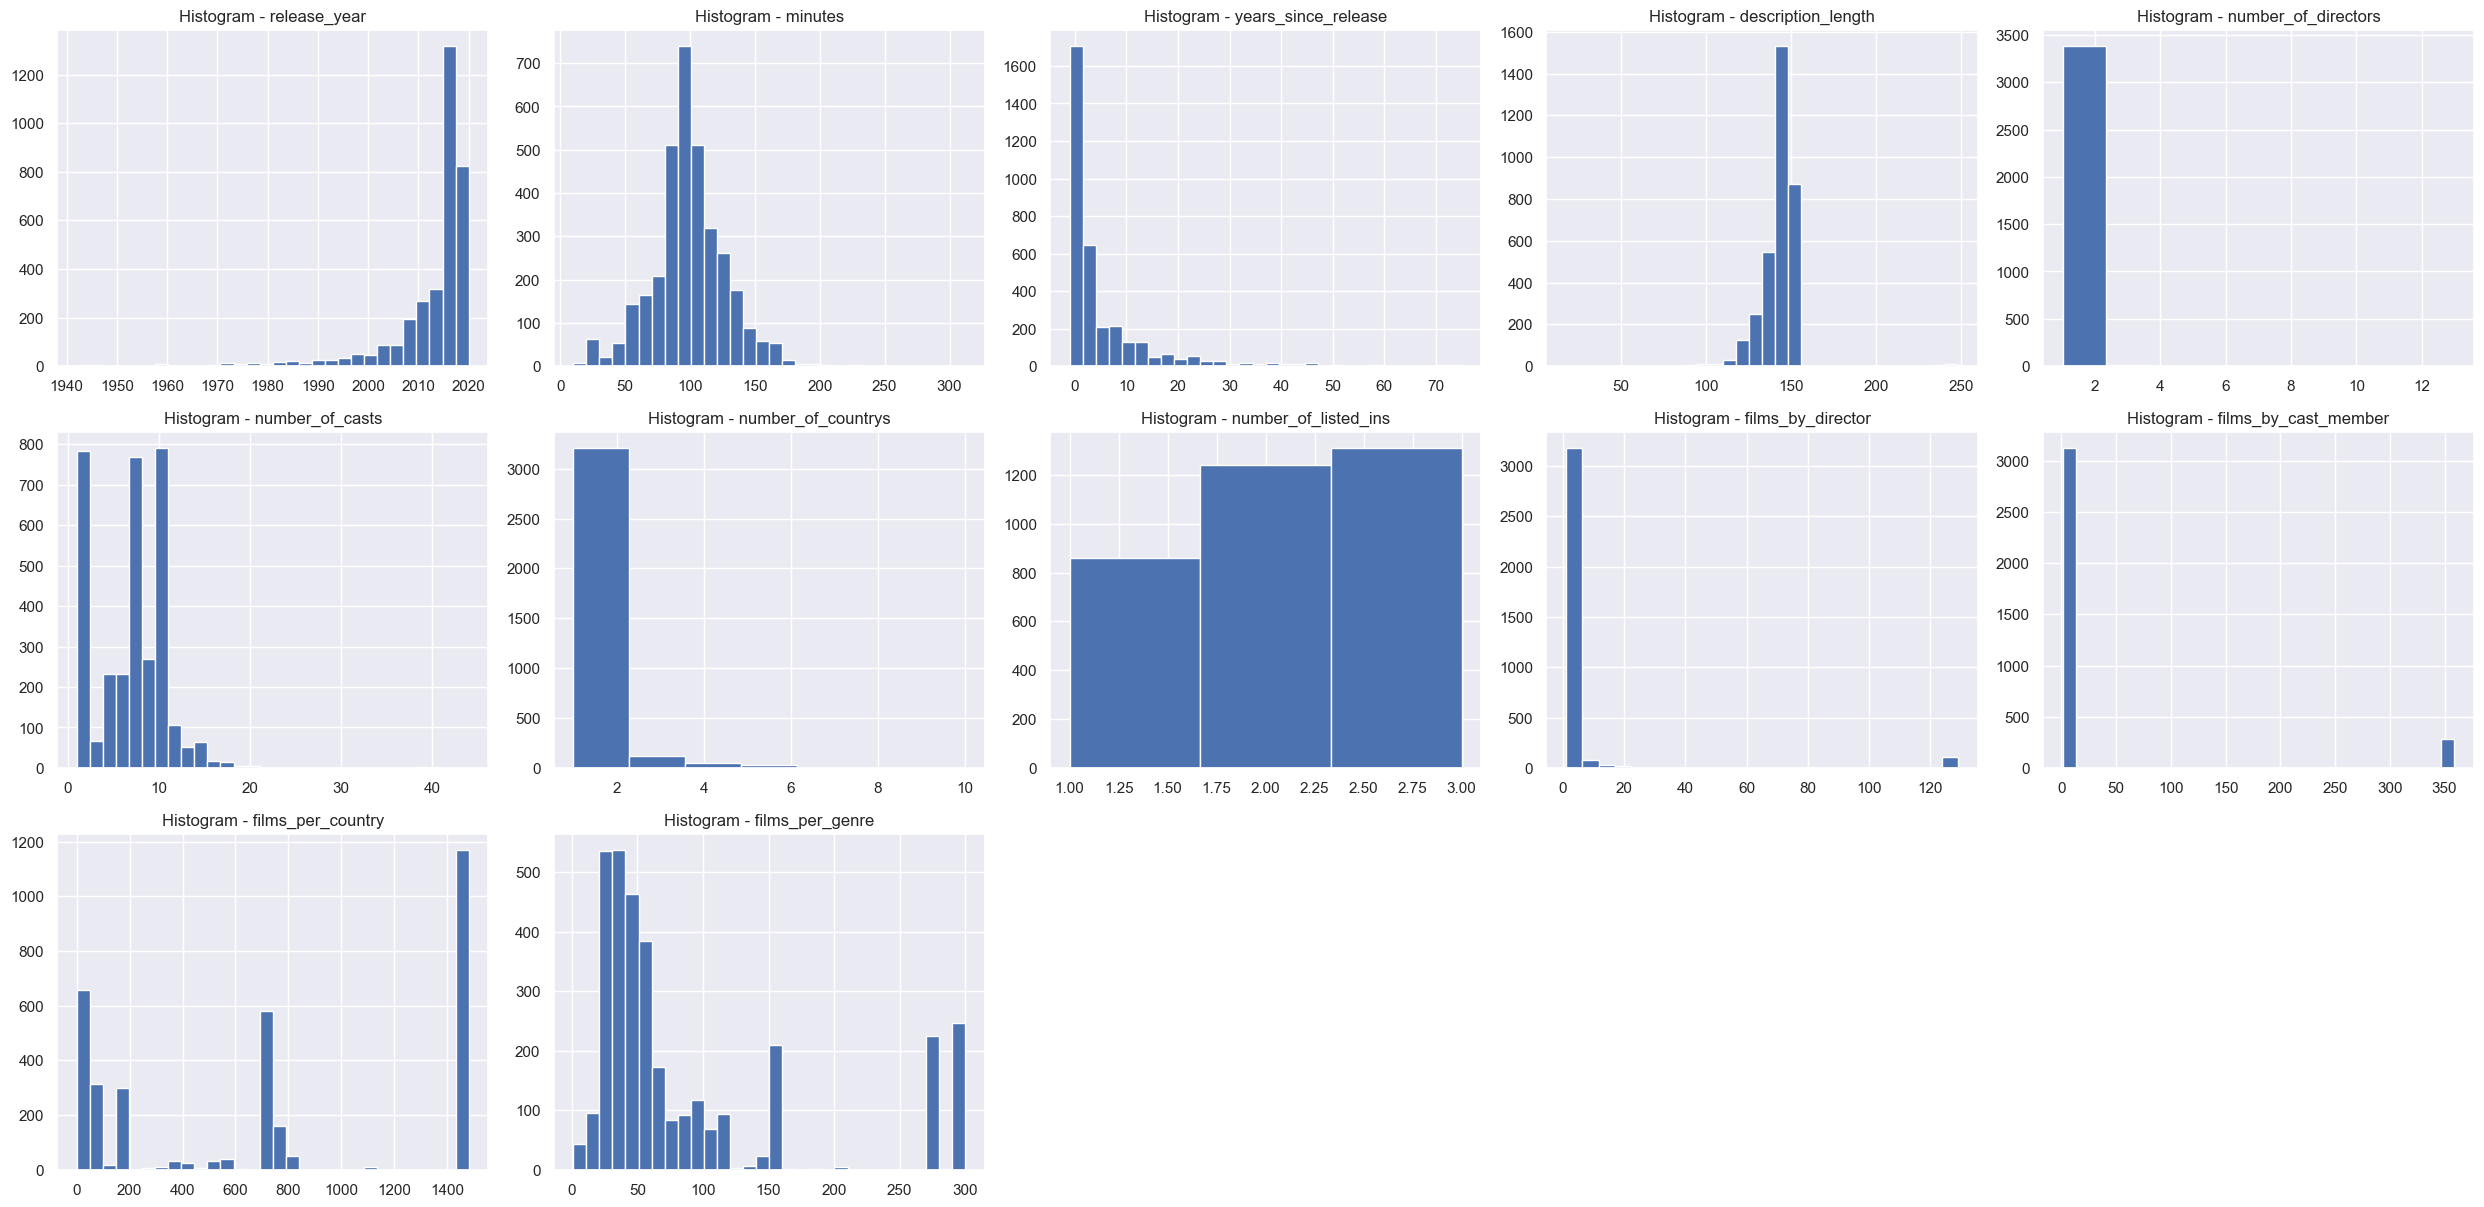

In [49]:
num_attributes = train_data.select_dtypes(include='number')
num_attributes.drop(['show_id', 'rating'], axis=1, inplace=True)
plot_histograms(num_attributes)

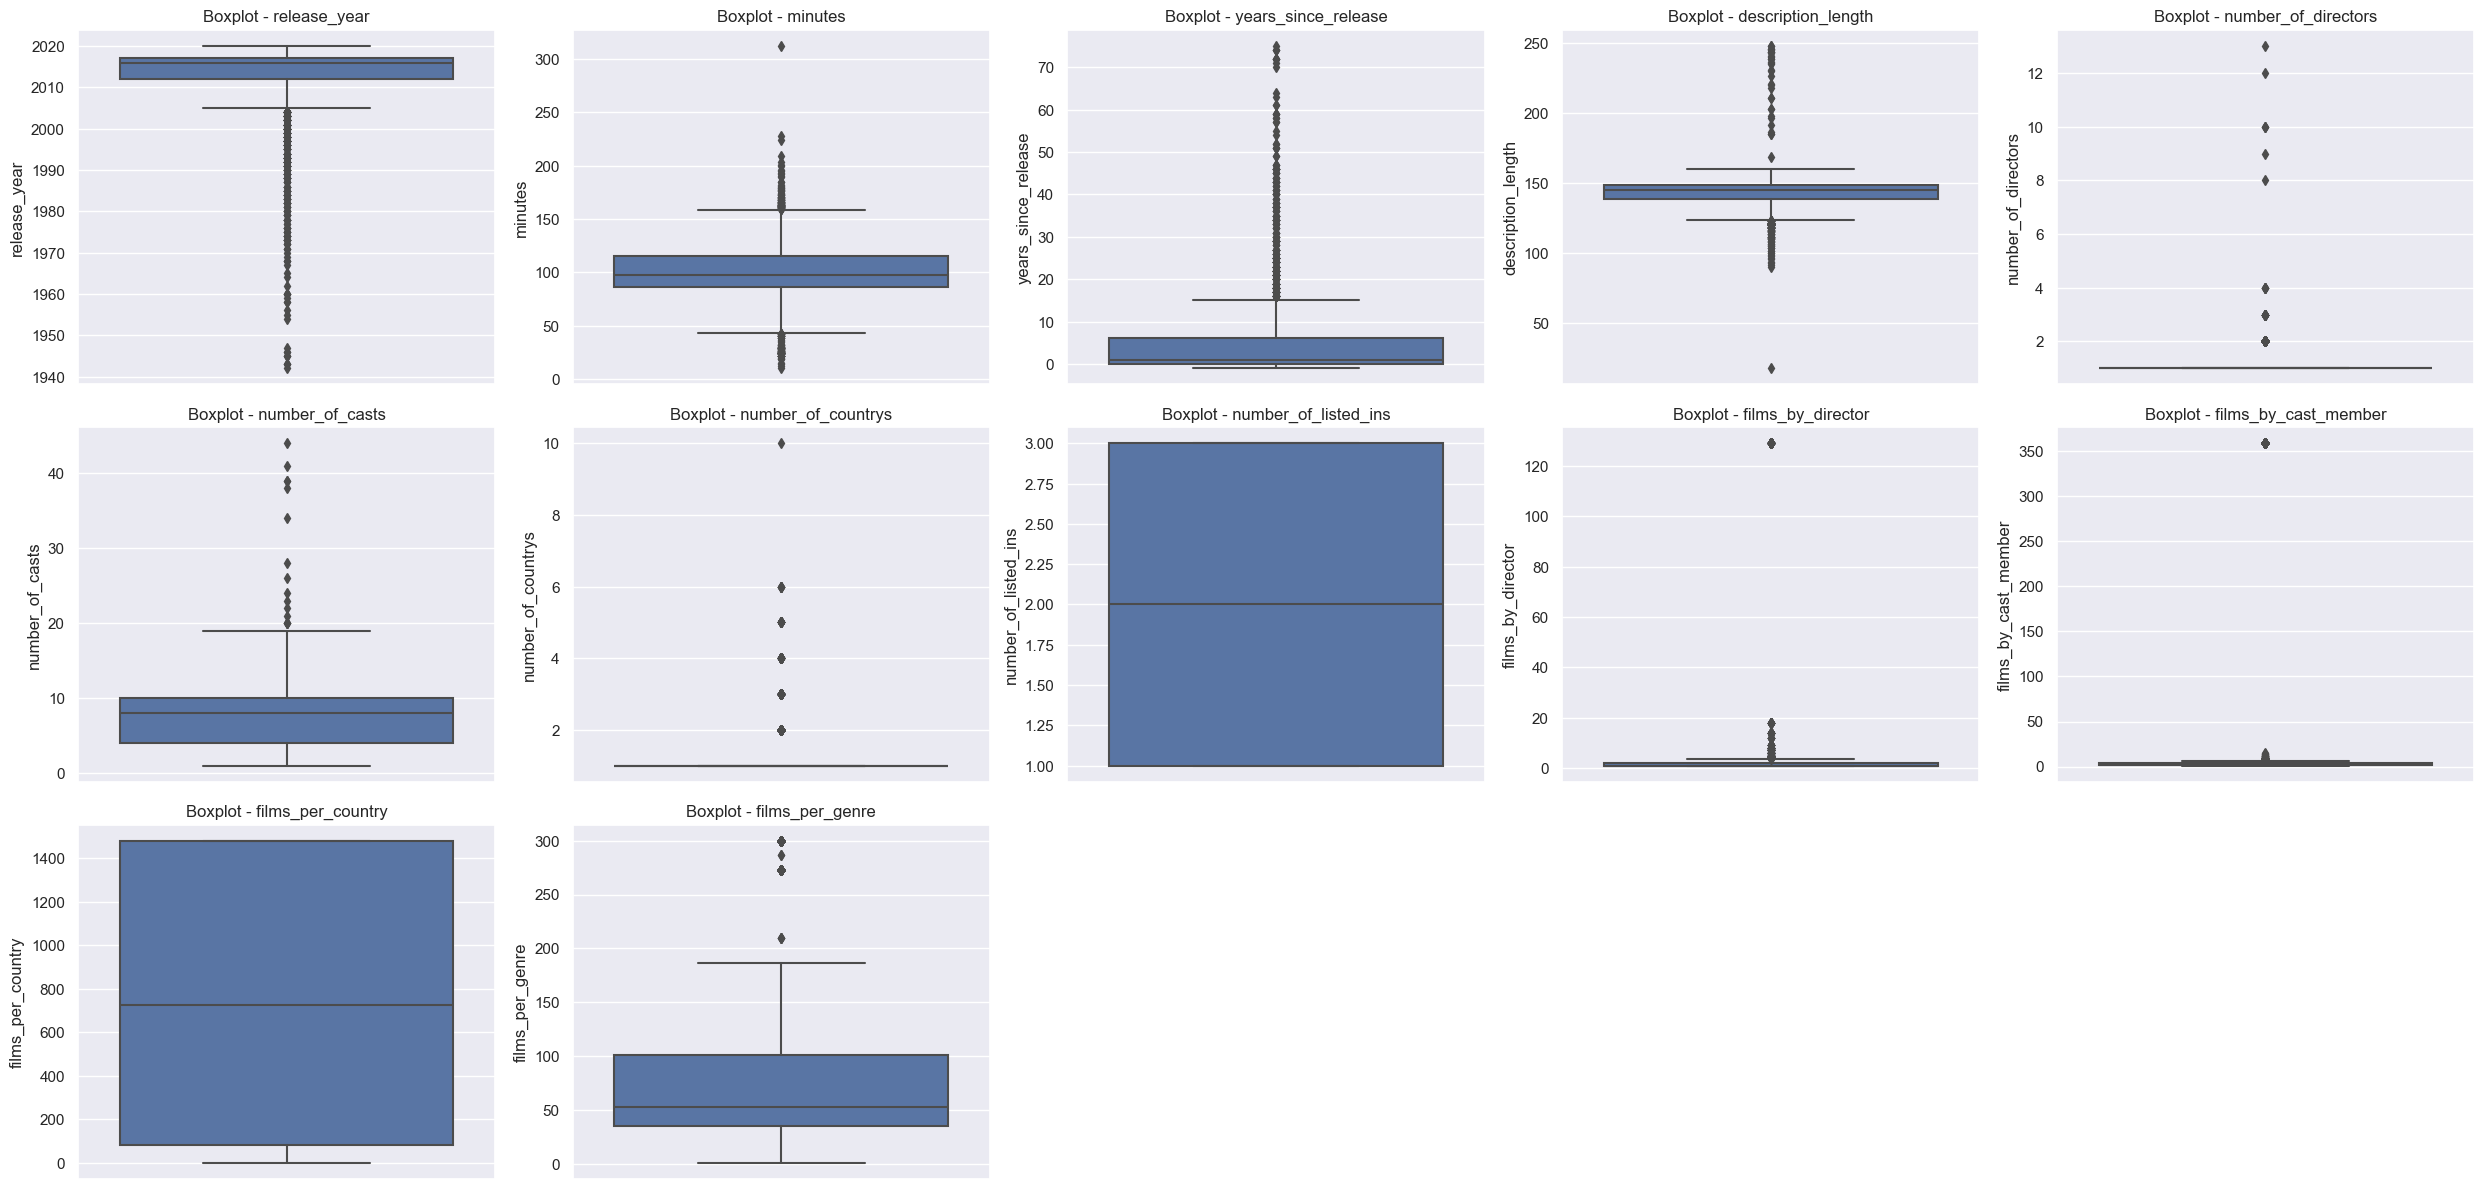

In [50]:
plot_boxplots(num_attributes)

When analyzing distributions, we look for those that resemble normal distributions, while boxplots help us understand the behavior of outliers.

This result allows us to choose techniques that preserve the distribution of the data.

In [51]:
ss = preprocessing.StandardScaler()
mms = preprocessing.MinMaxScaler()
rs = preprocessing.RobustScaler()

cols_to_standard = ['minutes']
cols_to_min_max = ['number_of_listed_ins', 'films_per_country']
cols_to_robust = ['release_year', 'years_since_release', 'description_length',
                  'number_of_directors', 'number_of_casts', 'number_of_countrys',
                  'films_by_director', 'films_by_cast_member', 'films_per_genre']

for col in cols_to_standard:
    train_data[col] = ss.fit_transform(train_data[[col]].values)
    validation_data[col] = ss.transform(
        validation_data[[col]].values
    )

for col in cols_to_min_max:
    train_data[col] = mms.fit_transform(train_data[[col]].values)
    validation_data[col] = mms.transform(
        validation_data[[col]].values
    )

for col in cols_to_robust:
    train_data[col] = rs.fit_transform(train_data[[col]].values)
    validation_data[col] = rs.transform(
        validation_data[[col]].values
    )

## 4.3 Transformation

### 4.3.1 Encoding

In [52]:
# Label - Doesn't respect an order, works well with a lot of single values
cols_to_label = ['title', 'cast', 'description', 'movie_stage']

le = preprocessing.LabelEncoder()

for col in cols_to_label:
    train_data[col] = le.fit_transform(train_data[col])
    # Check if there is something not mapped in validation data
    validation_data[col] = validation_data[col].map(
        lambda s: "unknown" if s not in le.classes_ else s
    )
    # Add the new class 'unknown' if it is not present
    if "unknown" not in list(le.classes_):
        le.classes_ = np.append(le.classes_, "unknown")
    else:
        # The class 'unknown' is already present, ensure that it occurs only once
        le.classes_ = np.unique(le.classes_)
    validation_data[col] = le.transform(validation_data[col])

# Ordinal - preserve the order
duration_dict = {'short' : 1, 'medium' : 2, 'long' : 3}
train_data['duration_bins'] = train_data['duration_bins'].map(duration_dict)
validation_data['duration_bins'] = validation_data['duration_bins'].map(duration_dict)

# Frequency encoding - useful for high cardinality columns
cols_to_frequency = ['director', 'country', 'listed_in']

for col in cols_to_frequency:
    fe_encoder = train_data.groupby(col).size() / len(train_data)
    train_data.loc[:, col] = train_data[col].map(fe_encoder)
    
    # For validation data, replace values with their respective frequencies.
    # If the value is not found in the mapping (from train_data), replace with the average frequency from train_data.
    validation_data.loc[:, col] = validation_data[col].map(fe_encoder).fillna(fe_encoder.mean())

### 4.3.2 Response Variable Transformation

The prediction of a model can be biased according to the distribution of the response variable, as we analyzed in the exploratory data analysis notebook we need to convert the variable to a normal distribution.

In [53]:
train_data['rating'], lambda_value = yeojohnson(train_data['rating'])

yeojohnson_transformation = pd.Series(lambda_value, index=['value'])

In [54]:
catalog.save("train_data_preparation", train_data)
catalog.save("validation_data_preparation", validation_data)
catalog.save("yeojohnson_transformation", yeojohnson_transformation)

[09/23/23 17:41:41] INFO     Saving data to 'train_data_preparation' (CSVDataSet)...            ]8;id=112944;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=150692;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'validation_data_preparation' (CSVDataSet)...       ]8;id=325291;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=242202;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'yeojohnson_transformation' (PickleDataSet)...      ]8;id=675352;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=476991;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\